# Lab 0: Introduction to Reddit Data

In this lab, we'll cover:
- What reddit data look like
- Several ways to summarize the conversation's tone
- Evaluation of data over time

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

%matplotlib inline

## Getting data
- Data files with Reddit comments are publicly available many places online, including torrents, google's BigQuery, and several data hosting websites. UM keeps a full copy in our Advanced Research Computing resources.
- Reddit is one of the biggest sites on the internet. 
    - It has over 3.5 billion comments, and the data take up several TB of disk space (`1 TB = 1024 GB`)! 
    - This makes working with the data difficult.
    - For simplicity, we went ahead and used some big data tools like `pyspark` and `hadoop` to go through all the comments and select out smaller sets to work with in this lab. 
- Let's start by looking at just the comments from the subreddit community for the University of Michigan
    - This file is only 34 MB: a more managable size!
    - The `shape` property tells us that there are 66 thousand rows (comments) and 28 columns.

In [2]:
#read the data
um_comments = pd.read_csv('data/merged/uofm.tsv', sep='\t')
#convert our dates to the date data type
um_comments['date'] = pd.to_datetime(um_comments.date)
#show the shape of our table
um_comments.shape

(67699, 29)

### What information do we have about each comment?
- We have a lot! Here are some of the most interesting columns:
    - `body` the text of the comment
    - `author` the username of the person who posted it
    - `date` when the comment was made
    - `subreddit` which community a comment is from. Here, they're all from `r/uofm`
    - `politeness` scores, computed by the [Stanford NLP group's software](https://www.cs.cornell.edu/~cristian/Politeness.html), tell us how "polite" a comment is, from 0 (not at all) to 1 (very polite). The program that gives these scores was designed primarily for comments where someone was replying to a request.
    - `sentiment` (how positive or negative a comment is), computed by the [VADER program in NLTK](http://www.nltk.org/_modules/nltk/sentiment/vader.html). (-1 is very negative, 0 is neutral, and 1 is very positive). 
    - `pej_nouns`: Sometimes when an adjective for people is used as a noun, it takes on a pejorative meaning. Research has found this is often true for the words "female," "gay," "poor," and "illegal," so this column counts the number of times those words (or versions of them like "females") are used as nouns. For more information, see this paper:
        - Palmer, Alexis, Melissa Robinson, and Kristy Philips. 2017. “[Illegal Is Not a Noun: Linguistic Form for Detection of Pejorative Nominalizations](http://www.aclweb.org/anthology/W17-3014).” Pp. 91–100 in *Proceedings of the First Workshop on Abusive Language Online.* Vancouver.
    - Several scores from the [Perspective API](https://www.perspectiveapi.com/). In this project, Google and Jigsaw teamed up to build automatic systems for finding bad comments. We used their program to score these comments already, and the scores are saved in the file.
        - `ATTACK_ON_COMMENTER` the probability that this comment is a personal attack on another commenter 
        - `INCOHERENT` whether the comment seems to make sense (high values don't make sense).
        - `INFLAMMATORY` how inflammatory the comment is
        - `LIKELY_TO_REJECT` the liklihood that New York Times comment editors would reject  the comment if it was posted on their site 
        - `OBSCENE` probability that the comment is obscene
        - `TOXICITY` probability that the comment is 'toxic' for community discussion
    

In [3]:
um_comments.columns.values

array(['date', 'author', 'body', 'politeness', 'sentiment',
       'controversiality', 'TOXICITY', 'ATTACK_ON_COMMENTER',
       'INFLAMMATORY', 'LIKELY_TO_REJECT', 'OBSCENE', 'SEVERE_TOXICITY',
       'ATTACK_ON_AUTHOR', 'SPAM', 'UNSUBSTANTIAL', 'INCOHERENT',
       'pej_nouns', 'ups', 'edited', 'id', 'is_submitter', 'parent_id',
       'replies', 'score', 'subreddit', 'deleted', 'stickied', 'archived',
       'collapsed'], dtype=object)

In [4]:
um_comments.head()

,date,author,body,politeness,sentiment,controversiality,TOXICITY,ATTACK_ON_COMMENTER,INFLAMMATORY,LIKELY_TO_REJECT,...,id,is_submitter,parent_id,replies,score,subreddit,deleted,stickied,archived,collapsed
0,2016-12-18 03:59:06,NinetyNine90,On the bright side it makes getting campus job...,0.500000,0.5617,0,0.097784,0.592016,0.498772,0.285933,...,dbbx41l,NaN,t1_dbbla80,NaN,39,uofm,0,False,NaN,NaN
1,2016-12-18 04:03:19,Ivor97,Wolverine Access is great. It's just really u...,0.437878,0.0343,0,0.607831,0.239917,0.450659,0.352783,...,dbbx9b9,NaN,t1_dbbwd0l,NaN,29,uofm,0,False,NaN,NaN
2,2016-12-18 04:22:56,Shadowhawk109,IIRC spring break coincides with project 3 of ...,0.452687,0.3548,0,0.027826,0.265231,0.363987,0.583996,...,dbbxxb7,NaN,t3_5ivbxv,NaN,4,uofm,0,False,NaN,NaN
3,2016-12-18 04:31:29,[deleted],[deleted],NaN,NaN,0,NaN,NaN,NaN,NaN,...,dbby7ol,NaN,t1_dbbla80,NaN,4,uofm,1,False,NaN,NaN
4,2016-12-18 04:33:34,1gaybro,In my experience the Greyhound picks you up at...,0.494651,0.0000,0,0.030083,0.727338,0.182881,0.490436,...,dbbya6k,NaN,t3_5iyj2y,NaN,5,uofm,0,False,NaN,NaN


### Example comments
- This randomly selects one of the comments and shows the text. 
- Run it multiple times to see different randomly chosen comments

In [5]:
print(um_comments.sample(1).body.iloc[0])

You're good, I use mine everyday and I graduated a year ago. The drivers don't check or ask you, and their card readers don't seem to check for much information. I know my friend had reported an old card as lost and they "deactivated" it in their system but she could still use it on the bus.


#### Helper function for finding examples of comments that score high or low
Run this code and scroll down.

In [6]:
def get_example(data, column, where='high'):
    #pick whether to use high or low scoring comments
    if where == 'high':
        asc = False
    else:
        asc = True
    #Select the 100 most extreme comments in this column
    df = data.sort_values(by=column, ascending=asc).head(100)
    #pick one at random and print the text of it
    print(df.sample(1).body.iloc[0])
    return

### What do all those scores mean? (They're not perfect!)
- **Run the code below, trying different column names** to see examples of comments that scored high or low in each measure.  
    - The function `get_example()` picks a comment at random, so run it more than once with `alt`+`enter` and you'll see different comments.
    - Do you notice a pattern with the types of comments that come up? 
    - Do any of the scores seem to mean something a little different than you expected?
- Note that the scores don't always seem right. For example, sometimes a comment that scored high in `ATTACK_ON_COMMENTER` isn't actually a personal attack.
    - The scores were made by some of the most advanced software for this in the world, and they're still not perfect. This reminds us just how hard it is for computers to understand human language.
- Still, most of the scores seem about right. And, as we know from statistics, we can still make inferences about average scores even when there are some errors in our measurements.

In [7]:
get_example(data=um_comments, column='sentiment', where='high')

wow great  thats great  gj


In [8]:
get_example(data=um_comments, column='sentiment', where='low')

and apparently some racism too  edit:  lots of racism too


In [9]:
get_example(data=um_comments, column='politeness', where='low')

Jesus it's rough enough being homeless, why would you force them to sit on steel benches through this


In [10]:
get_example(data=um_comments, 
            column='ATTACK_ON_COMMENTER', where='high')

yup.  Don't be a moron, get a decent GPA, do one or two major things that your given school within UofM will appreciate.  What school are you planning on going into?  And just make sure that you can write a good application letter. You don't have to be a genius, you just have to come across as competent and passionate.


In [11]:
get_example(data=um_comments, column='TOXICITY', where='high')

Fuck *some* frats  FTFY


In [12]:
get_example(data=um_comments, column='OBSCENE', where='high')

Spoken like a true wolverine. "Disagree with me? Then fuck off!"


### Getting a feel for our data
- One of the first things to do with any data is plot it. We want to get a feel for what's in it. 
- Some of the scores are normally distributed, like sentiment and politeness. 
    - What might this mean?
    - Why might there be a spike of comments with exactly 0 (totally neutral) sentiment?
- The distributions of other scores, like personal attacks and obscenity are very skewed. 
    - Most comments are nice (low scores), but a few are not (high scores). 

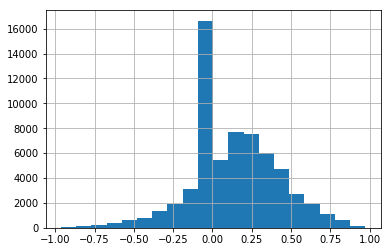

In [13]:
um_comments.sentiment.hist(bins=20)

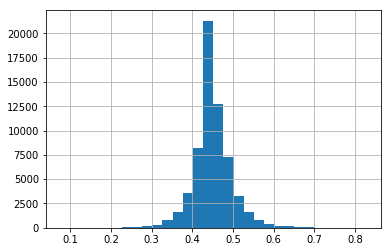

In [14]:
um_comments.politeness.hist(bins=30)

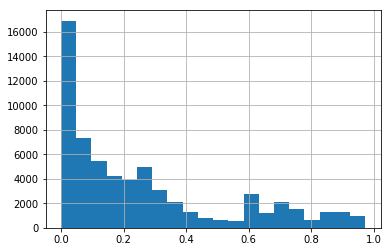

In [15]:
um_comments.ATTACK_ON_COMMENTER.hist(bins=20)

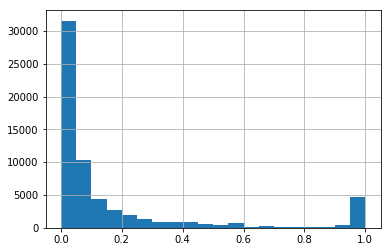

In [16]:
um_comments.OBSCENE.hist(bins=20)

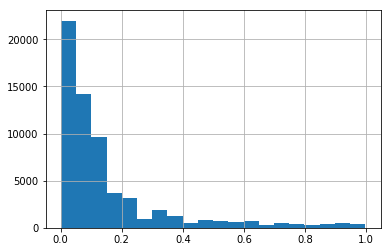

In [17]:
um_comments.TOXICITY.hist(bins=20)

## Seeing trends over time
- In this lab, we're not just interested in individual comments, but in the community (in this case, a subreddit forum) and how it changes over time. 
- To study this, we're going to be using the `groupby` and `resample` functions in pandas. They're two slightly different functions that do the same basic thing:
    - Take all of our comments and put them into groups (in our case, one group for each month).
    - Summarize each group (e.g. by telling us how many comments are in it or what their average score is).
- Once we have summaries for each group, we can plot them on a graph where the X axis is time. Take a look at the examples below.

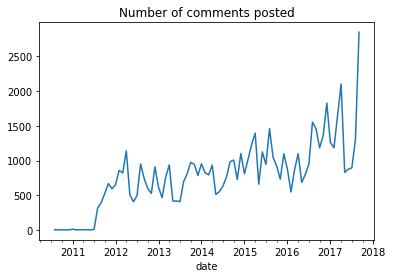

In [18]:
#Group the comments by month
monthly = um_comments.resample('M', on='date')

#count the number of comments in ach group
total_comments = monthly.body.count()

#show first few months
total_comments.plot(title='Number of comments posted')

#### We can make the plots prettier with this helper function.
Don't worry about how this code works, just run it and scroll down.

In [19]:
def make_plot(grouped, columns='id', title=None, top=None, bottom=None, 
             games=None, exams=None, classes=None, agg='mean',
             years=[2012, 2018]):
    
    fig, axs = plt.subplots(figsize=(14,10))
    if bottom is not None:
        axs.set_ylim(bottom=bottom)
    if top is not None:
        axs.set_ylim(top=top)
    
    if years is not None:
        axs.set_xlim(left=datetime(year=years[0], month=1, day=1), 
                     right=datetime(year=years[1], month=1, day=1))
    
    if games is not None:
        for g in games.iterrows():
            if g[1].game_result == 'W':
                axs.axvline(g[1].date, color='k', alpha=.6)
            elif g[1].game_result == 'L':
                axs.axvline(g[1].date, color='r', alpha=.6)
                
    if exams is not None:
        for e in exams.iterrows():
            if e[1].exams == 1:
                axs.axvline(e[1].date, color='r', alpha=.5)
                
    if classes is not None:
        for c in classes.iterrows():
            axs.axvspan(c[1].class_start, c[1].class_end, 
                        color='g', alpha=0.35)
                
    if isinstance(columns, str):
        columns = [columns]
        
    if agg == 'mean':
        for c in columns:
            means = grouped[c].mean()
            sems = grouped[c].sem()
            axs.plot(means.index, means)
            axs.fill_between(sems.index, means-(1.96*sems), 
                             means+(1.96*sems), alpha=0.5)

        if title is None:
            title = 'Average scores with 95% confidence interval'
    elif agg == 'count':
        for c in columns:
            counts = grouped[c].count()
            axs.plot(counts)
        if title is None:
            title = 'Number of comments per month'
    elif agg == 'unique':
        for c in columns:
            counts = grouped[c].nunique()
            axs.plot(counts)
        if title is None:
            title = 'Number of unique ___ per month'
    axs.set_title(title)
    axs.legend()
                
    plt.show()
    return

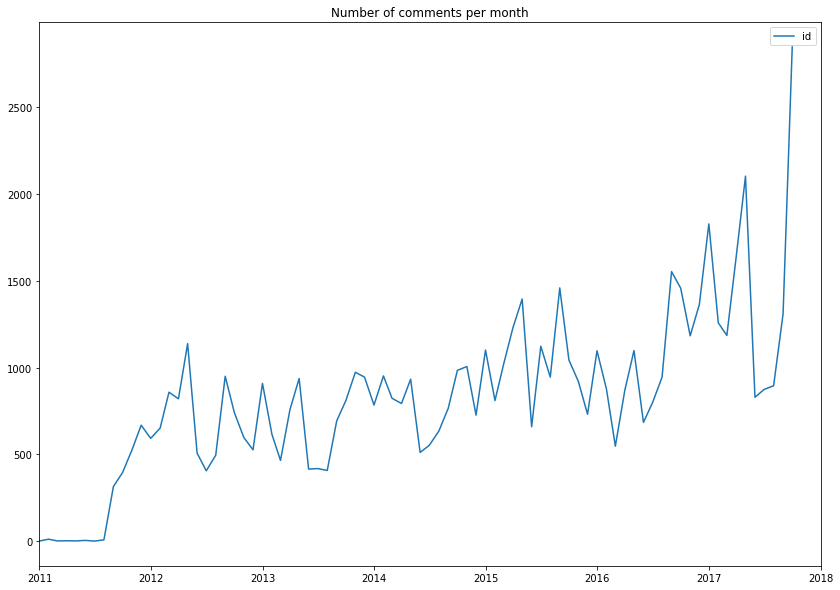

In [20]:
make_plot(monthly, agg='count', years=[2011,2018])

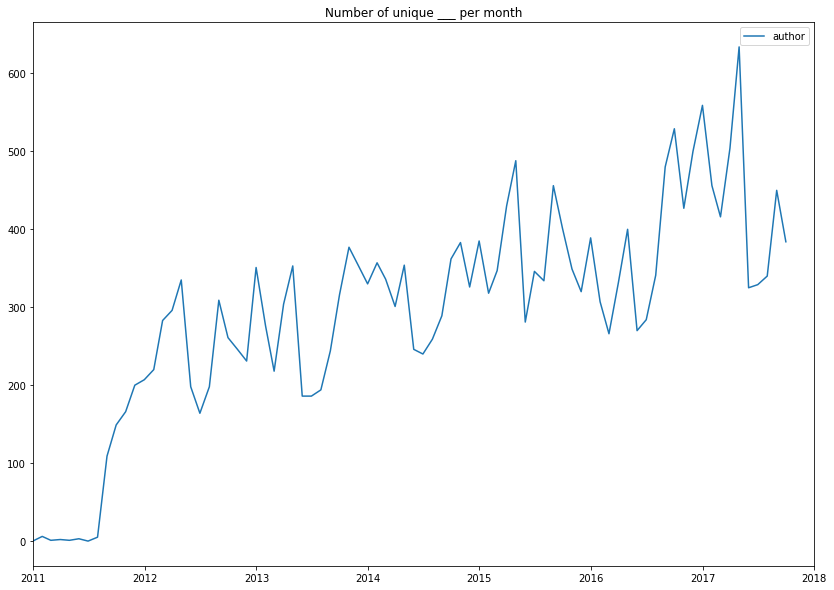

In [21]:
make_plot(monthly, columns='author', agg='unique', years=[2011,2018])

### Looking for patterns
- Do you notice a pattern in the number of comments or active users over time?
    - It is a little messy, but it seems like there are less people posting comments in the middle of each year (summer time). Why might that be? 
    
### What about the comment scores? 
- We can plot the average score of comments each month.
- Because the score is an average, it also has a standard error.
- We'll write a simple helper function to make nice plots of the averages and the confidence interval around them.
- **Try it yourself**:
    - Call the function `make_plot()` with different column names to see different plots. 
    - You can also call it with multiple column names in a list, like in the third example.
    - **Hint** you can change the range of the y axis by setting the arguments `top` and `bottom`. Otherwise they'll be chosen automatically. 

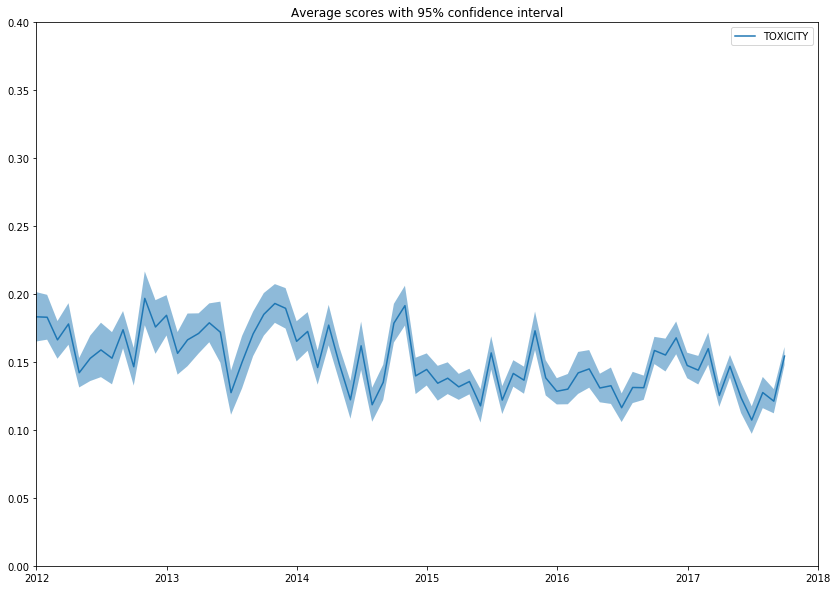

In [22]:
make_plot(monthly, columns='TOXICITY', top=.4)

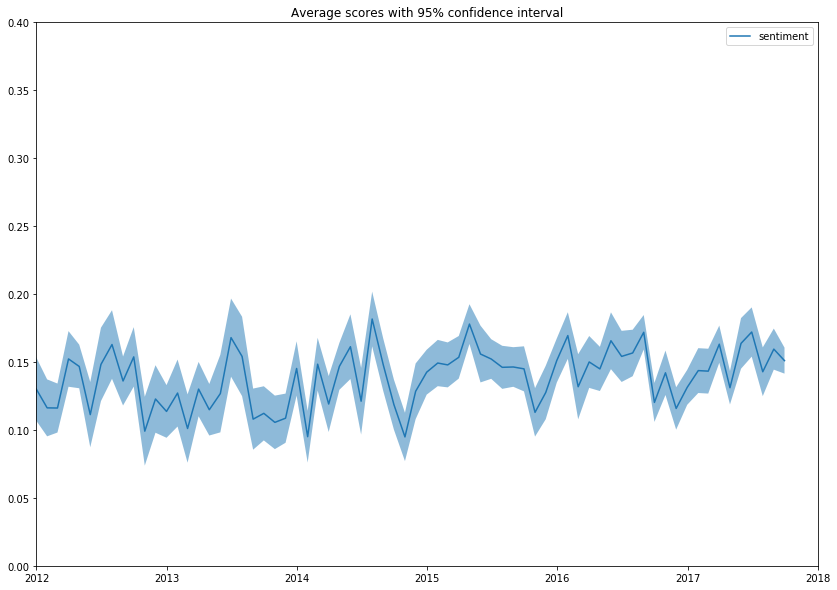

In [23]:
make_plot(monthly, columns='sentiment', top=.4)

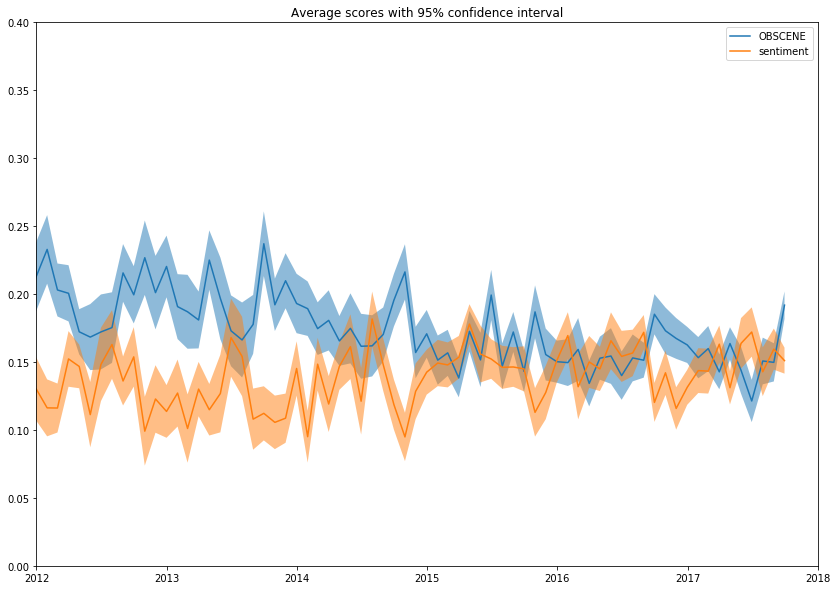

In [24]:
make_plot(monthly, columns=['OBSCENE', 'sentiment'], top=.4)

### Adding events
- Maybe some of the patterns we see in the data corrispond to events happening at the same time. 

#### Let's load data about when UM classes are in session 

In [25]:
#read data
classes = pd.read_csv('data/UM_class_periods_no_summer.tsv', sep='\t')
#convert dates to date data type
classes['class_start'] = pd.to_datetime(classes.class_start)
classes['class_end'] = pd.to_datetime(classes.class_end)
#show the most recent information
classes.tail()

,class_start,class_end
56,2017-09-05,2017-11-22
57,2017-11-27,2017-12-12
58,2018-01-03,2018-02-24
59,2018-03-05,2018-04-17
60,2018-09-04,2018-11-21


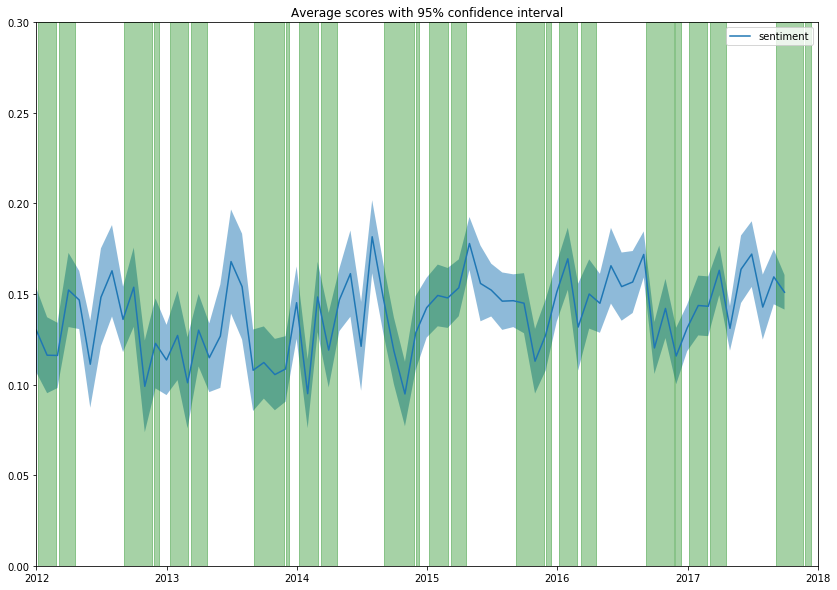

In [26]:
make_plot(monthly, columns=['sentiment'], classes=classes, top=.3)

#### See a pattern?
- The graph is green during times when classes are in session, and white otherwise.
- Sentiment on the r/uofm subreddit seems to get more negative when Summer ends and Fall semester begins each year.
- Does that happen for the other scores? **Try the function with different column names** instead of `sentiment` to see. 

#### What about final exams?
- Load data on exams

In [27]:
exams = pd.read_csv('data/UM_academic_calendar_no_summer.tsv', sep='\t')
exams['date'] = pd.to_datetime(exams.date)
exams.tail()

,event,times,date,exams,class_start,class_stop
325,Classes resume 8:00 a.m.,"Nov 26, Mon",2018-11-26,0,1,0
326,Classes end,"Dec 11, Tues",2018-12-11,0,0,1
327,Study Days,"Dec 12, Wed & Dec 15-16, Sat-Sun",2018-12-12,0,0,0
328,Examinations,"Dec 13-14, Thur-Fri & Dec 17-20, Mon-Thur",2018-12-13,1,0,0
329,Commencement,"Dec 16, Sun",2018-12-16,0,0,0


#### Helper functions
- Don't worry about how this code works, just run it and scroll down.

In [28]:
def make_plot2(grouped, columns='id', title=None, top=None, bottom=None, 
             games=None, exams=None, classes=None, agg='mean'):
    
    fig, axs = plt.subplots(figsize=(14,10))
    if bottom is not None:
        axs.set_ylim(bottom=bottom)
    if top is not None:
        axs.set_ylim(top=top)
                
    if isinstance(columns, str):
        columns = [columns]
        
    axs.axvline(0, color='k', alpha=.5)
        
    if agg == 'mean':
        for c in columns:
            means = grouped[c].mean()
            sems = grouped[c].sem()
            axs.plot(means.index, means)
            axs.fill_between(sems.index, means-(1.96*sems), 
                             means+(1.96*sems), alpha=0.5)

        if title is None:
            title = 'Average scores with 95% confidence interval'
    elif agg == 'count':
        for c in columns:
            counts = grouped[c].count()
            axs.plot(counts)
        if title is None:
            title = 'Number of comments per month'
    elif agg == 'unique':
        for c in columns:
            counts = grouped[c].nunique()
            axs.plot(counts)
        if title is None:
            title = 'Number of unique ___ per month'
    axs.set_title(title)
    axs.set_xlabel('Days Since Exams Started')
    axs.legend()
                
    plt.show()
    return

def center_on_dates(comments, dates, window_size=14):
    subset = []
    for d in dates.date:
        start = d - pd.Timedelta(window_size, unit='d')
        end = d + pd.Timedelta(window_size+1, unit='d')
        tmp = comments[(comments.date >= start) & 
                          (comments.date <= end)].copy()
        tmp['days'] = tmp.date.apply(lambda x: (x - d).days)
        subset.append(tmp)

    subset = pd.concat(subset)
    return subset.groupby(by='days')

In [29]:
exam_weeks = center_on_dates(um_comments, exams)

### Plots showing posts one week before and after finals start
- The black bar shows when finals start.
    - Note that we added together the two weeks before and after finals for every semester, so what you see is the total over all. That's why the X axis is "days since exams started" rather than a specific date.

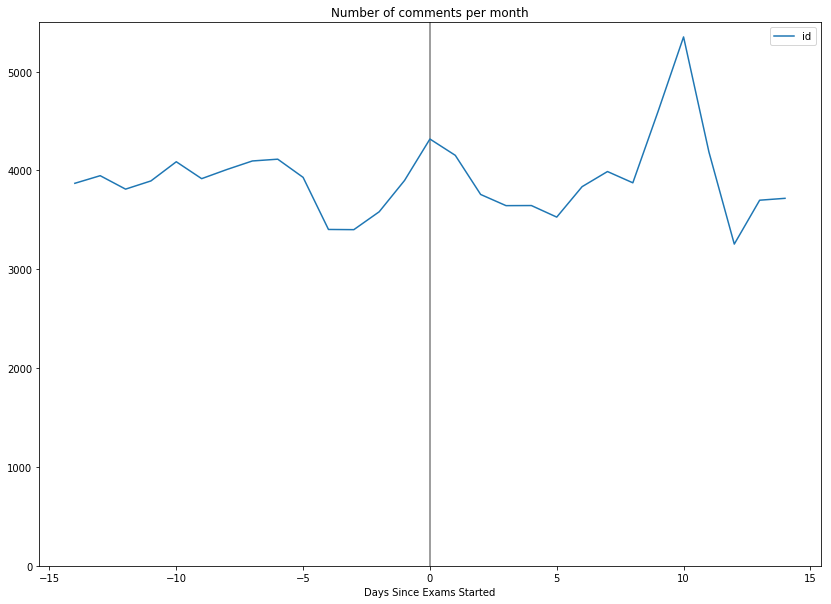

In [30]:
make_plot2(exam_weeks, agg='count', bottom=0, top=5500)

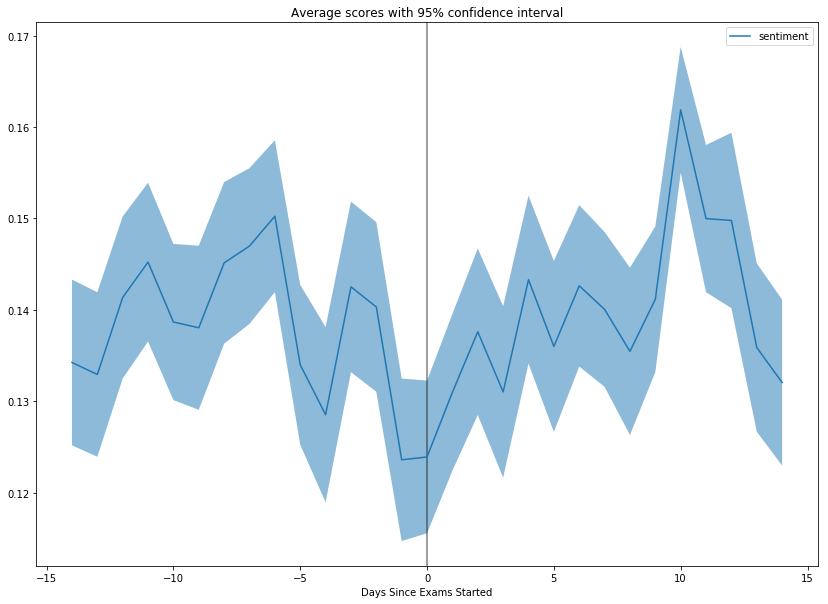

In [31]:
make_plot2(exam_weeks, columns='sentiment')

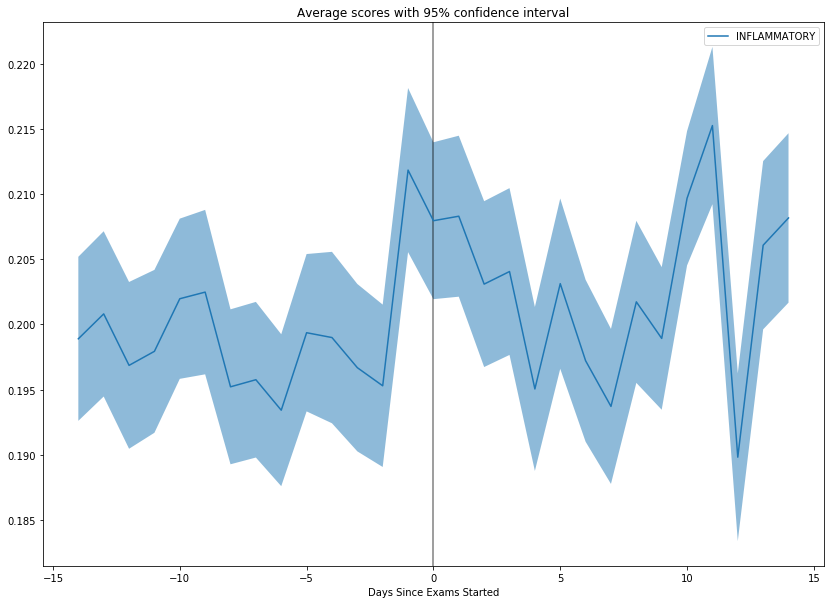

In [32]:
make_plot2(exam_weeks, columns='INFLAMMATORY')

#### See a pattern?
- There doesn't seem to be a strong relationship between exams and sentiment. That's okay. Sometimes research finds that there is nothing to be found. 
- **Try it yourself**: do exams corrispond with trends in scores other than sentiment?

### Football games
- Load data from the subreddit for UM athletics and the dates of football games.

In [33]:
sports_comments = pd.read_csv('data/merged/MichiganWolverines.tsv', 
                              sep='\t')
sports_comments['date'] = pd.to_datetime(sports_comments.date)

games = pd.read_csv('data/UM_football.tsv', sep='\t')
games['date'] = pd.to_datetime(games.date)
games.head()

,conf_abbr,date,game_location,game_result,game_streak,losses,notes,opp_name,opp_points,points,school_name,ties,time_game,wins
0,Ind,1881-10-31,@,L,L 1,1,"Boston, MA",Harvard,1,0,Michigan,0.0,NaN,0
1,Ind,1881-11-02,@,L,L 2,2,NaN,Yale,2,0,Michigan,0.0,NaN,0
2,Ind,1881-11-04,@,L,L 3,3,NaN,Princeton,1,0,Michigan,0.0,NaN,0
3,Non-Major,1883-03-12,NaN,W,W 1,0,NaN,Detroit A.C.,5,40,Michigan,0.0,NaN,1
4,Ind,1883-11-19,@,L,L 1,1,NaN,Wesleyan (CT),14,6,Michigan,0.0,NaN,1


#### Just for fun, what is our all time win / loss record?

In [34]:
games.game_result.value_counts()

W    917
L    331
T     35
Name: game_result, dtype: int64

### Game day sentiment

In [35]:
win_days = center_on_dates(sports_comments, 
                           games[games.game_result == 'W'], 
                           window_size=7)
loss_days = center_on_dates(sports_comments, 
                           games[games.game_result == 'L'], 
                           window_size=7)
osu_games = games[games.opp_name.apply(lambda n: 'Ohio State' in n)]
osu_days = center_on_dates(sports_comments, osu_games, window_size=7)
msu_games = games[games.opp_name.apply(lambda n: 'Michigan State' in n)]
msu_days = center_on_dates(sports_comments, msu_games, window_size=7)

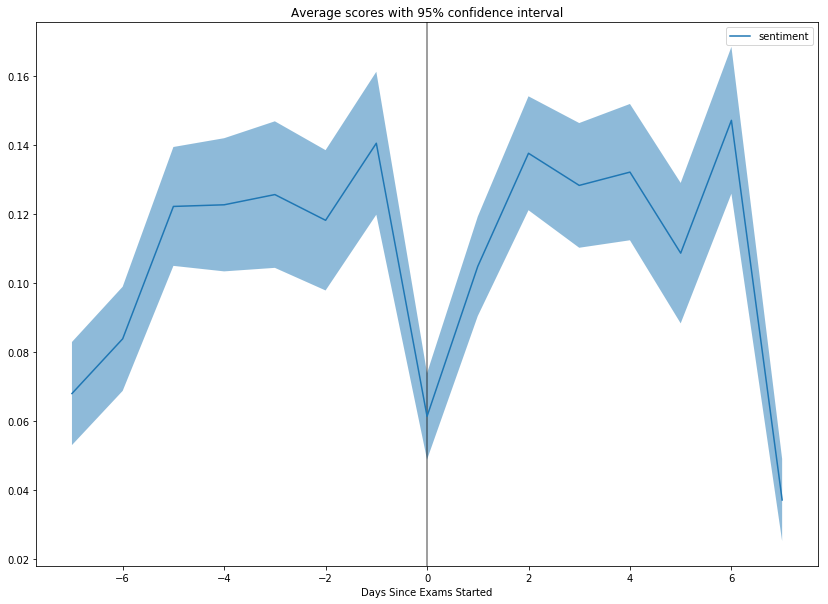

In [36]:
make_plot2(win_days, columns='sentiment')

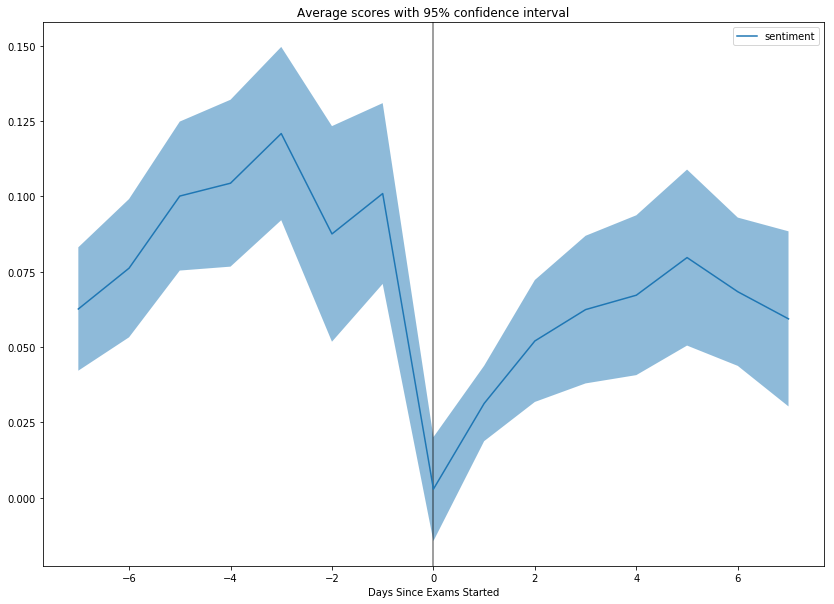

In [37]:
make_plot2(loss_days, columns='sentiment')

## What we learned:
1. What reddit is, and what comment data looks like.
2. Various ways of scoring comments to summarize their contents.
3. The difficulty of getting good scores.
4. Grouping data by time and showing trends in average comment scores.
5. Comparing time series data with events.